<a href="https://colab.research.google.com/github/mifumo081a/HobbyColabProjects/blob/main/Dataset_and_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset And Dataloader

# オンライン学習，バッチ学習，**ミニバッチ学習**[3-5]
- オンライン学習 (online learning)
  - 学習データ1つずつを使用して逐次的に最適化する手法
  - 学習データ集合をすべて学習するまで，学習データ1つずつを使用した更新式を反復処理する
  - 勾配降下法(Gradient descent; GD)において，特に学習データ集合から学習データをランダム()に選んで最適化する手法を確率的勾配降下法(Stochastic gradient descent; SGD)という．
  - 更新式に使う目的関数は反復処理の度に違うため，局所的な極小解に陥るリスクがバッチ学習より低くなる．
  - しかしながら，1つずつに対して勾配を計算して更新するため，誤差が振動することがある．
- バッチ学習 (full batch learning)
  - 学習データ集合の全学習データを使用して一度に更新式を処理する
  - GDでは，全学習データでの誤差を合計する
  - これは最小化する目的関数が常に同じであるため，局所的な極小解の1つに陥る可能性がある
  - 凸な誤差面に対しては大域的な極小解に，非凸な誤差面に対しては局所解に収束する．
- **ミニバッチ学習 (mini batch learning)**
  - 学習データ集合から少数データ集合をひとまとめにして使用する集合を"ミニバッチ (mini-batch)"という
  - このミニバッチごとの目的関数の平均を使用して更新します（ミニバッチの大きさで目的関数の大きさが変わらないように）．
  - 学習データ集合の一部を用いて更新するため，最小化する目的関数は変化し，バッチ全体の勾配を計算して更新するため，誤差が振動しづらく，局所的な極小解に陥りにくい（上2つのいいとこどり）
  - ミニバッチ学習はオンライン学習より有用である
    - オンラインに比べて更新式の計算速度が高い
    - GPUは行列同士の乗算のようなベクトル演算が得意
  - ミニバッチはクラスバランスをとる方が良い
    - ミニバッチに対して更新式が処理されるため，クラスごとの偏りができないように

# データを簡単にミニバッチで取り出す仕組みが欲しい．．．**Dataset, DataLoader**を使用するとそれが可能になります．

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

In [ ]:
# @title # 使用するCSVファイルをダウンロードします．

# https://gist.github.com/tijptjik/9408623
!wget -nc  -O wine_data.zip https://gist.github.com/tijptjik/9408623/archive/b237fa5848349a14a14e5d4107dc7897c21951f5.zip
!unzip -u -j wine_data.zip -d wine_data

print("↓↓↓こんなファイルです↓↓↓")
pd.read_csv("./wine_data/wine.csv").head()

--2023-06-19 05:31:29--  https://gist.github.com/tijptjik/9408623/archive/b237fa5848349a14a14e5d4107dc7897c21951f5.zip
Resolving gist.github.com (gist.github.com)... 140.82.114.3
Connecting to gist.github.com (gist.github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/9408623/zip/b237fa5848349a14a14e5d4107dc7897c21951f5 [following]
--2023-06-19 05:31:29--  https://codeload.github.com/gist/9408623/zip/b237fa5848349a14a14e5d4107dc7897c21951f5
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘wine_data.zip’

wine_data.zip           [ <=>                ]   4.57K  --.-KB/s    in 0.001s  

2023-06-19 05:31:29 (4.31 MB/s) - ‘wine_data.zip’ saved [4680]

Archive:  wine_data.zip
b237fa5848349a14a14e5d4107dc7897

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# まず，データ集合からデータを読み込む処理を自分で書いてみましょう．
- オンライン学習はシンプルで，データを1つずつ読みだして更新式を反復処理するだけです．
- バッチ学習に関しては，データ集合をテンソルとして扱うことができるため一括でモデルに入出力することを過程するとよりシンプルになります．（通常はメモリに乗らないため，データ1つずつの合計を取る）
- ミニバッチ学習は，バッチサイズの定義，データセットをミニバッチごとに取り出す処理などが含まれるため，複雑になっています．

### ※本当は，SGDではデータ集合の中からランダム()にバッチやデータを選択する必要があるため処理はより複雑になります．ここでは単純化しています．

In [ ]:
data = np.loadtxt("./wine_data/wine.csv", delimiter=",", dtype=np.float32, skiprows=1)

# オンライン学習
for epoch in range(10):
  # データであるベクトルと，ラベルを代入する
  X, Y = data[:, 1:], data[:, 0]
  for x, y in zip(X, Y):
    pass
    # forward + backward + model parameters updates

# バッチ学習
for epoch in range(10):
  X, Y = data[:, 1:], data[:, 0]
  # forward + backward + model parameters updates


# ミニバッチ学習
for epoch in range(1):
  X, Y = data[:, 1:], data[:, 0]
  batch_size = 20
  total_batches = X.shape[0] // batch_size
  print(f"Dataset size: {X.shape[0]}, Batch_size: {batch_size}, Total batches: {total_batches}")

  batch_head = 0

  for i in range(total_batches):
    x_batch, y_batch = X[batch_head : batch_size*(i+1)], Y[batch_head : batch_size*(i+1)]
    batch_head = batch_size*(i+1)
    print(x_batch.shape)
    # forward + backward + model parameters updates
  else:
    x_batch, y_batch = X[batch_head:], Y[batch_head:]
    print(x_batch.shape)
    # forward + backward + model parameters updates

Dataset size: 178, Batch_size: 20, Total batches: 8
(20, 13)
(20, 13)
(20, 13)
(20, 13)
(20, 13)
(20, 13)
(20, 13)
(20, 13)
(18, 13)


# Dataset，DataLoaderとは
- データの読み出しを簡単化し，読みやすさとモジュール化のために，データセットのコードはモデルの学習コードとは切り離しておきたい．
- PyTorchでは，`torch.utils.data.Dataset`, `torch.utils.data.DataLoader`という２つのクラスが提供されている．
- Datasetは学習データと対応するラベルを格納，読み出しをするオブジェクトである
- DataLoaderはDatasetに`iterable`をラップしてデータに簡単にアクセスできるようにするものです．
  - `iterable`とは`next`メソッドやfor文の`in ～`で繰り返し処理ができるオブジェクトのことです

- Datasetはデータ集合を定義するもの，DataLoaderはデータ集合からサンプリングするものと考えるとわかりやすいと思います

## Datasetオブジェクト
- `torch.utils.data.Dataset`クラスを親クラスとして継承した子クラスを宣言します
- Datasetオブジェクトはあくまでも，データを使うためのクラスとして存在します．例えば，使い方としては次のような使い方が想定されます．
- 正しく宣言するには最低限次の3つのメソッドをオーバーライドしなければなりません
  - `__init__`
    - Datasetオブジェクトをインスタンス化する際に1度だけ実行される
    - 画像やベクトル，対応するラベル，変換(次の人が説明する)を初期化します
  - `__len__(self)`
    - データセットの大きさを返す関数
  - `__getitem__(self, index)`
    - データセットから`index`で参照できるデータを返す
    - 別にデータと対応するラベルという2つを返す必要はなく，何個でもよい

- 宣言したDatasetを`dataset`としてインスタンスしたとすると，`dataset[index]`で`index`に対応するデータを返す

# PyTorchは、実数はfloat型，ラベル(0, 1, 2とか)はlong型にするように

In [ ]:
class WineDataset(Dataset):
  def __init__(self, root=os.getcwd()):
    # csvファイルを読み出す
    file_path = os.path.join(root, "wine.csv")
    xy = np.loadtxt(file_path, delimiter=",", dtype=np.float32, skiprows=1)
    self.n_samples = xy.shape[0]

    # 学習データのベクトルを代入する
    self.x_data = torch.from_numpy(xy[:, 1:])
    # 学習データに対応するラベルを代入する
    self.classes = list(np.unique(xy[:, 0]))
    self.y_data = torch.tensor([self.classes.index(i) for i in xy[:, 0]], dtype=torch.long)

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.x_data[idx], self.y_data[idx]

In [ ]:
# datasetインスタンスの宣言
data_folder_path = "./wine_data/"
dataset = WineDataset(data_folder_path)

# 0番目のindexに対応するデータを取得する
features, labels = dataset[0]
print(features.shape)
print(features)
print(labels.shape)
print(labels)

torch.Size([13])
tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03])
torch.Size([])
tensor(0)


## DataLoaderオブジェクト
- Datasetオブジェクトはデータセットのデータとラベルを一度に1つずつ取得します
- ミニバッチ学習をするのは近年において一般的となり，データをミニバッチで渡し，エポックごとにデータをシャッフルしてモデルが局所的な極小解に収束するリスクを減らし，Pythonのマルチプロセッシングを利用してデータの読み出しを高速化します
- DataLoaderは，これらの複雑な処理を簡単に実行できる`iterable`オブジェクトです

## WineDatasetのDataLoaderを宣言します．

In [ ]:
print("CPU number of threads: ", os.cpu_count())

# WineDatasetインスタンスを読み出すDataLoaderを宣言する
train_loader = DataLoader(dataset=dataset, # DataLoaderに与えるDatasetインスタンス
                          batch_size=4, # ミニバッチの大きさ
                          shuffle=True, # shuffleするかどうか
                          num_workers=2, # データの読み出しに使用するCPUの論理スレッド数を指定します．2で十分であり，2以上はそれほど差がない
                          pin_memory=True # CPUのメモリ領域がページングされないようにピン留めされた状態となり、CUDAのautomatic memory pinningが使用できるようになる。
                          )

# iter()はiteratorオブジェクトを返す．iterableオブジェクトを与える
# next()はiteratorオブジェクトの__next__()メソッドを呼び出し，iteratorから次の項目を取得する
features, labels = next(iter(train_loader))

print("Dataloaderから読みだされるテンソルは次のshapeになるはずです．[B, (データのshape)] (B: バッチサイズ)")
print()

print(features.shape)
print(features)
print(labels.shape)
print(labels)

CPU number of threads:  2
Dataloaderから読みだされるテンソルは次のshapeになるはずです．[B, (データのshape)] (B: バッチサイズ)

torch.Size([4, 13])
tensor([[1.2840e+01, 2.9600e+00, 2.6100e+00, 2.4000e+01, 1.0100e+02, 2.3200e+00,
         6.0000e-01, 5.3000e-01, 8.1000e-01, 4.9200e+00, 8.9000e-01, 2.1500e+00,
         5.9000e+02],
        [1.3400e+01, 4.6000e+00, 2.8600e+00, 2.5000e+01, 1.1200e+02, 1.9800e+00,
         9.6000e-01, 2.7000e-01, 1.1100e+00, 8.5000e+00, 6.7000e-01, 1.9200e+00,
         6.3000e+02],
        [1.3830e+01, 1.5700e+00, 2.6200e+00, 2.0000e+01, 1.1500e+02, 2.9500e+00,
         3.4000e+00, 4.0000e-01, 1.7200e+00, 6.6000e+00, 1.1300e+00, 2.5700e+00,
         1.1300e+03],
        [1.1820e+01, 1.4700e+00, 1.9900e+00, 2.0800e+01, 8.6000e+01, 1.9800e+00,
         1.6000e+00, 3.0000e-01, 1.5300e+00, 1.9500e+00, 9.5000e-01, 3.3300e+00,
         4.9500e+02]])
torch.Size([4])
tensor([2, 2, 0, 1])


# 元の資料[1]では実際に学習しなかったけど，ここでは実際に学習してみましょう．

In [ ]:
# @title ## モデルの定義
!pip install torchinfo
import torchinfo

class my_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13, 16)
    self.fc2 = nn.Linear(16, 16)
    self.fc3 = nn.Linear(16, 3)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.sigmoid(self.fc3(x))
    return x

# print(my_model())
torchinfo.summary(my_model(), (1, 13))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
my_model                                 [1, 3]                    --
├─Linear: 1-1                            [1, 16]                   224
├─ReLU: 1-2                              [1, 16]                   --
├─Linear: 1-3                            [1, 16]                   272
├─ReLU: 1-4                              [1, 16]                   --
├─Linear: 1-5                            [1, 3]                    51
├─Sigmoid: 1-6                           [1, 3]                    --
Total params: 547
Trainable params: 547
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

#  学習の反復処理をする関数の定義

In [ ]:
def train(model, dataloader, loss_func, optimizer, num_epochs):
  dataset_size = len(dataloader.dataset)
  device = next(model.parameters()).device

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = np.inf
  best_acc = 0.
  loss_list, acc_list = [], []

  n_iterations = len(dataloader) # number of batches
  print(f"Dataset size: {dataset_size}, Number of batches: {n_iterations}")
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for i, (inputs, labels) in enumerate(dataloader): # ←←←ここ注目!!!
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, dim=1)
      match = torch.sum(preds == labels)

      epoch_loss += loss.item() * inputs.shape[0]
      epoch_acc += match.item()

      if (i+1) % 5 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations} | Inputs {inputs.shape} | Labels {labels.shape}")
    loss_list.append(epoch_loss / dataset_size)
    acc_list.append(epoch_acc / dataset_size)
    print("Loss: {:.4f}, Accuracy: {:.4f}".format(epoch_loss/dataset_size, epoch_acc/dataset_size))

    if epoch_loss <= best_loss or epoch_acc >= best_acc:
      best_loss = epoch_loss
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model, loss_list, acc_list

## 学習

In [ ]:
n_samples = len(dataset)
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

# データセットを疑似乱数で分割する関数(seedがあるよ!!)
# 3つに分割することもできる
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("All dataset size: ", len(dataset))
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = my_model().to(device)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epochs = 30

model_ft, loss_list, acc_list = train(model, train_loader, loss_func, optimizer, num_epochs)

All dataset size:  178
Train dataset size:  142
Test dataset size:  36
cuda
Dataset size: 142, Number of batches: 36
Epoch: 1/30, Step 5/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 10/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 15/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 20/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 25/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 30/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 1/30, Step 35/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Loss: 1.0641, Accuracy: 0.3803
Epoch: 2/30, Step 5/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 2/30, Step 10/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 2/30, Step 15/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([4])
Epoch: 2/30, Step 20/36 | Inputs torch.Size([4, 13]) | Labels torch.Size([

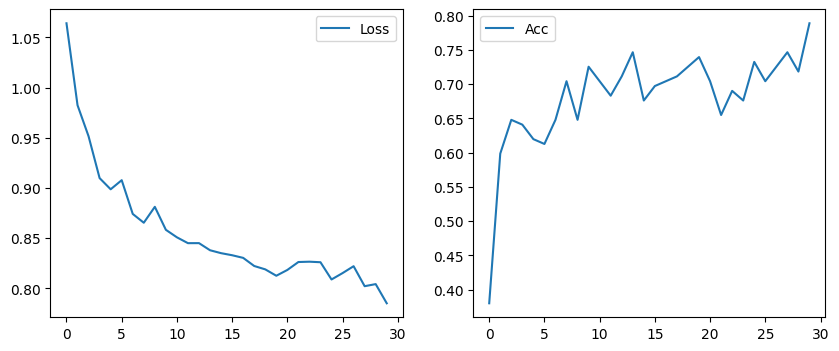

In [ ]:
fig = plt.figure(figsize=(10, 4))
fig.add_subplot(121)
plt.plot(loss_list, label="Loss")
plt.legend()
fig.add_subplot(122)
plt.plot(acc_list, label="Acc")
plt.legend()
plt.show()

In [ ]:
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

model_ft.eval()
with torch.no_grad():
  outputs = model_ft(inputs)

  _, preds = torch.max(outputs, dim=1)

print("Ground truth: ", labels.item())
print("Prediction: ", preds.item())

Ground truth:  0
Prediction:  0


# 有名な公開データセットを使う
PyTorch関連のライブラリでは，`torch.utils.data.Dataset`のサブクラスで，多くの読み込み済みのデータセット (ex. MNIST, CIFAR10, etc...) を提供しています．プロトタイプやベンチマークに使うことができると考えられる．次の項目から探すことができます．
- [Image Datasets](https://pytorch.org/vision/stable/datasets.html)
- [Text Datasets](https://pytorch.org/text/stable/datasets.html)
- [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

## ここでは，手書き文字認識の代表的なデータセットであるMNISTを読み込んでみる

In [ ]:
train_dataset = torchvision.datasets.MNIST(root="./data", # ダウンロードするtrain/testデータを格納するファイルパスを指定
                                           train=True, # trainデータかtestデータか指定する．ベンチマークはテストデータが指定済みであるものが多い．
                                           transform=torchvision.transforms.ToTensor(), # データとラベルに施す変換を指定する（次の人が説明するところ）．
                                           download=True # rootで指定したパスから読み出せない場合，インターネットからダウンロードする
                                           )

train_dataset = torchvision.datasets.CIFAR10(root="./cifar10",
                                             train=True,
                                             transform=torchvision.transforms.ToTensor(),
                                             download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=3,
                          shuffle=True
                          )

100%|██████████| 9912422/9912422 [00:00<00:00, 101791477.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29238642.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28174194.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4877247.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:09<00:00, 18083890.51it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


cpu
torch.Size([3, 3, 32, 32]) torch.Size([3])


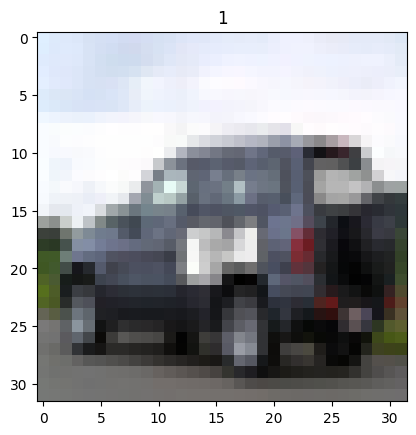

In [ ]:
inputs, labels = next(iter(train_loader))
print(inputs.device)
print(inputs.shape, labels.shape)

plt.figure()
plt.imshow(inputs[0].permute(1, 2, 0).numpy(), cmap="gray")
plt.title(labels[0].numpy())
plt.show()

# Appendix

## DataLoaderから読み出す度にGPUに載せないといけないけど、最初から載せられないの？
- 今、DataLoaderの宣言時にdeviceを指定する仕様について議論が行われており、開発が進んでいます。
[URL](https://github.com/pytorch/pytorch/pull/40746)
- また、別の解決策もあります。それは、Datasetのクラス変数またはインスタンス変数として持っているtorch.Tensorを`to(deivce)`でGPUに載せるという方法です。[URL](https://stackoverflow.com/questions/65327247/load-pytorch-dataloader-into-gpu)
  - しかしながら、この方法は一部の前処理やDataLoaderの設定である`num_workers`や`pin_memory`を使えなくなるため、やはりまだDataLoaderから読み出した後にGPUに載せる方が良いでしょう。
  - ただし、`torchvision.datasets`のDatasetではできなかった。おそらくクラスの定義で変数を変更できないようにしているのでしょう。

In [ ]:
dataset = WineDataset(data_folder_path)

dataset.x_data = dataset.x_data.to(device)
dataset.y_data = dataset.y_data.to(device)

dataloader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          )

features, labels = next(iter(dataloader))

print(features.shape)
print(features)
print(labels.shape)
print(labels)

## データ集合からのサンプリング手法は指定できないの？
- `torch.utils.data.DataLoader`クラスは`sampler`引数を用いてSamplerオブジェクトを指定することができます．
- `torch.utils.data.Sampler`クラスは，データの読み込みに使われるindexなどのsequenceを指定するために使われます．これはデータセットへのindexを反復するオブジェクトを表します．例えば，
  - SGDの場合，Samplerはindexのリストをランダムに並び替え，一度に1つずつ取得する
  - ミニバッチSGDの場合，少数のindexを取得する
- また，`torch.utils.data.DataLoader`クラスの`batch_sampler`引数を用いて，一度に複数のindexを取得するSamplerオブジェクトを指定することができます．
- `DataLoader()`の引数で`shuffle=False`と指定した場合，データセットから順番に読み込む`SequentialSampler`，`shuffle=True`と指定した場合，重複無しでランダムな順番で読み込む`RandomSampler`が使用されます．

In [ ]:
dataset = WineDataset(data_folder_path)

class SequentialSampler(torch.utils.data.Sampler):
  def __init__(self, dataset):
    self.dataset = dataset

  def __iter__(self):
    return iter(range(len(self.dataset)))

sampler = SequentialSampler(dataset)

for i in sampler:
  print(i, end=" ")
print()

batch_size=1
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=(sampler is None),
                        sampler=sampler,
                          )

dataloader_iter = iter(dataloader)
for i in range(2):
  print(dataset[i*batch_size:(i+1)*batch_size])
  print(next(dataloader_iter))

In [ ]:
class SequentialBatchSampler(torch.utils.data.Sampler):
  def __init__(self, dataset, batch_size):
    self.dataset = dataset
    self.batch_size = batch_size
    self.count = 0
    self.total_batches = len(self.dataset) // self.batch_size

  def __iter__(self):
    batches_list = []
    batch_head = 0
    for i in range(self.total_batches):
      batches_list.append(list(range(batch_head, self.batch_size*(i+1))))
      batch_head = self.batch_size*(i+1)
    else:
      batches_list.append(list(range(batch_head, len(self.dataset))))

    return iter(batches_list)

  def __len__(self):
    return self.total_batches

batch_size=4
batch_sampler = SequentialBatchSampler(dataset, batch_size)
# batch_sampler = torch.utils.data.sampler.BatchSampler(sampler, batch_size, drop_last=False)
batch_dataloader = DataLoader(dataset=dataset,
                              shuffle=(batch_sampler is None),
                              batch_sampler=batch_sampler
                              )

for i in batch_sampler:
  print(i, end=" ")
print()

batchloader_iter = iter(batch_dataloader)
for i in range(2):
  print(dataset[i*batch_size:(i+1)*batch_size])
  print(next(batchloader_iter))

# Reference
1. Patrick Python Engineer, "Dataset And Dataloader - PyTorch Beginner 09", "Python Engineer", https://www.python-engineer.com/courses/pytorchbeginner/09-dataset-and-dataloader/
2. PyTorch, "DATASETS & DATALOADERS", "PyTorch Tutorials 1.11.0+cu102", https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
3. Geoffrey Hinton, "Overview of mini batch gradient descent", Neural Networks for Machine Learning on Coursera in 2012, Lecture 6.1, https://www.youtube.com/watch?v=4BZBog1Zx6c&ab_channel=ColinReckons
4. 岡谷貴之, "深層学習", 機械学習プロフェッショナルシリーズ，講談社，p23-39, (※補足　slideshareでここを解説したスライドがあったので共有します．https://www.slideshare.net/zakktakk/chapter3-62337101)
5. Sebastian Ruder, "An overview of gradient descent optimization algorithms", arxiv, 2016, https://arxiv.org/abs/1609.04747
6. xiongjie, "PytorchのDataLoaderの高速化のコツについてすこし解説", Zenn, 2022/04/10, https://zenn.dev/xiongjie/articles/0ae1378feb4204
7. Pystyle, "Pytorch - DataLoaderの使い方について解説", 2022/04/25, https://pystyle.info/pytorch-dataloader/#outline__8
8. @sugulu_Ogawa_ISID, "PyTorchでの学習・推論を高速化するコツ集", Qiita, 2020/09/08, 更新日2022/06/03, https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
9. PyTorch, "torch.utils.data", "PyTorch Tutorials 1.11.0+cu102", https://pytorch.org/docs/stable/data.html#
10. Scott Condron, "But what are PyTorch DataLoaders really?", Scott Condron's Blog, https://www.scottcondron.com/jupyter/visualisation/audio/2020/12/02/dataloaders-samplers-collate.html#Custom-Batch-Sampler